# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [2]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

gitpath=os.path.expanduser("~/git/cshlwork")
sys.path.append(gitpath)

from mapseq.core import * 
from cshlwork.utils import dataframe_to_seqlist, write_fasta_from_df, run_command_shell, NonZeroReturnException, setup_logging
from alignment.bowtie import run_bowtie, make_bowtie_df, make_adjacency_df

logging.getLogger().setLevel(logging.DEBUG)

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. 


In [3]:
cp = get_default_config()
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M229/Mseq229_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M229/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M229/out')
infiles = [
    os.path.expanduser('~/project/mapseq/M229/fastq/M229_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M229/fastq/M229_S1_R2_001.fastq.gz')
          ]
print("Done")

Done


In [6]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
rtlist = [int(x) for x in rtlist]
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
sampdf
bcolist

running new
7


[BarCodeHandler: label=BC281 barcode=TCGTGGTA df=
 None,
 BarCodeHandler: label=BC282 barcode=TATTGTAC df=
 None,
 BarCodeHandler: label=BC283 barcode=TTCGTGCT df=
 None,
 BarCodeHandler: label=BC284 barcode=CCCTGACC df=
 None,
 BarCodeHandler: label=BC285 barcode=ACCGATCT df=
 None,
 BarCodeHandler: label=BC287 barcode=ACAGGGAA df=
 None,
 BarCodeHandler: label=BC288 barcode=TGTTGCCA df=
 None]

In [7]:
# handle all the input. usually takes ~ minutes
# M229. 297M reads. 
process_fastq_pair(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
os.listdir(outdir)

2023-05-05 08:51:07,355 (UTC) [ INFO ] core.py:648 root.check_output(): all output exists.
2023-05-05 08:51:07,356 (UTC) [ INFO ] core.py:658 root.process_fastq_pair(): output_exists=True force=False
2023-05-05 08:51:07,357 (UTC) [ WARNING ] core.py:728 root.process_fastq_pair(): all output exists and force=False. Not recalculating.


['BC282.spike.seq.fasta',
 'BC281.spike.counts.tsv',
 'BC281.lone.btdf.tsv',
 'BC284.real.bowtie',
 'BC284.real.btdf.tsv',
 'BC281.real.raw.tsv',
 'BC288.32.counts.tsv',
 'unmatched.fasta',
 'BC283.lone.counts.tsv',
 'BC285.lone.btdf.tsv',
 'BC284.seq.raw.tsv',
 'BC283.fasta',
 'BC284.spike.btdf.tsv',
 'BC281.real.seq.fasta',
 'BC282.spike.bowtie',
 'BC281.fasta',
 'BC285.spike.bowtie',
 'BC287.lone.bowtie',
 'BC284.real.counts.tsv',
 'BC283.spike.btdf.tsv',
 'BC288.lone.raw.tsv',
 'BC282.lone.bowtie',
 'BC284.lone.tsv',
 'BC285.lone.tsv',
 'BC288.44.counts.tsv',
 'BC283.32.raw.tsv',
 'BC287.real.raw.tsv',
 'BC288.real.bowtie',
 'BC288.real.seq.fasta',
 'BC283.real.counts.tsv',
 'BC282.spike.btdf.tsv',
 'BC285.fasta',
 'BC288.seq.raw.tsv',
 'BC288.spike.raw.tsv',
 'BC281.real.bowtie',
 'BC284.lone.counts.tsv',
 'BC287.fasta',
 'BC287.real.btdf.tsv',
 'BC285.spike.btdf.tsv',
 'BC282.lone.btdf.tsv',
 'BC285.spike.counts.tsv',
 'BC281.seq.raw.tsv',
 'BC287.real.seq.fasta',
 'BC284.spike.b

In [17]:
tdflist = []
cdflist = []
outcdf = None
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    seqdf = make_fasta_df(cp, bch.filename)
    cdf = make_counts_df(cp, seqdf, bc_label=bch.label)  
    cdflist.append(cdf)
    if bch.label == 'BC285':
        outcdf = cdf
    threshold = calculate_threshold(cp, cdf)
    tdf = threshold_counts(cp, cdf)
    tdf['counts'] = 1
    tdf['sequence'] = tdf['sequence'].str[:32]
    bch.dataframe = make_counts_df(cp, tdf)
    tdflist.append(tdf)
alldf = BarCodeHandler.merge_counts(cp, tdflist)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-05-05 09:28:12,017 (UTC) [ INFO ] core.py:327 root.make_fasta_df(): kept 314537 sequences out of 314735
2023-05-05 09:28:12,066 (UTC) [ INFO ] core.py:301 root.make_counts_df():                                             sequence
0       AATGTTGTTGTTCCTTACATTCTACGTCAGTCCCTGGCTATTAG
1       CTTCCCATGCTTTTGGTGTATATACGTCAGTCCCTGTTTGTAAA
2       CGTTTCGGCCTCAAACGATGGACACGTCAGTCTTAGGGTGTACC
3       ATTTAATGAGATCGGTAGTTAATCCGTCAGTCTTTCCCACGCCA
4       CCGGCTTTTCACTTACTATTTGACCGTCAGTCAATGGTATGGGC
...                                              ...
314532  TATACATTTCCACAGTAATTGCGTCGTCAGTCATGTAGGTGAAG
314533  CTTCGTGTGGGGGCCGGCTTGATACGTCAGTCTTTGGTGATTGT
314534  GTTTTCTGCGTACGGAATGCCGCGCGTCAGTCGGAGGGTCATCC
314535  AGGACTCAGGGTATCACTGGGAGACGTCAGTCAGGTGATCTGCT
314536  GCTCGACAATGATGAAGTGATCAGCGTCAGTCGCTCCGTTCTAG

[314537 rows x 1 columns]
2023-05-05 09:28:12,124 (UTC) [ INFO ] core.py:374 root.threshold_counts(): thresh = 2
2023-05-05 09:28:12,129 (UTC) [ INFO ] core.py:301 root.make_counts

KeyboardInterrupt: 

In [18]:
outcdf = cdflist[2]
cdflist

[                                           sequence  counts bc_label
 0      ATCCTACCACCTATTATATCATTACGTCAGTCGGATTATTTCGT    3487    BC281
 1      CTCTGTAAGGAGGTTCCGTGAAATCGTCAGTCGGCCGTGTCAGG    3467    BC281
 2      GTGTAATTGGAATGGCCATCGAGACGTCAGTCATCCAAGTCTCC    3352    BC281
 3      TGGTGCGAGTAGTCTATCGAAGTTCGTCAGTCCGCGTACACTCG    2955    BC281
 4      CCGGCTTTTCACTTACTATTTGACCGTCAGTCAATGGTATGGGC    2907    BC281
 ...                                             ...     ...      ...
 14937  CTTGGCTCCAAGAGGGCTAGGCTGCGTCAGTCGTGTGCTACGTG       1    BC281
 14938  GTTGGTCTGAGGCCCTACTGGCGACGTCAGTCTGTCAAACTTCT       1    BC281
 14939  ATCCTACCACCTATTATATCATTACGTCAGTCGGATTATTTCCT       1    BC281
 14940  CCGCCAGGTGCAGGGAGGGGGAGACGTCAGTCGACGGTACAGAA       1    BC281
 14941  TCTCCTAGGGTGGCTCTTTAGGTCCGTCAGTCAGGGACTTTATG       1    BC281
 
 [14942 rows x 3 columns],
                                            sequence  counts bc_label
 0      AATGTATAATAACCTCGTAAATAGTTTTAATCTGAAGTTGTGAG    1916 

In [26]:
outcdf[outcdf.counts > 0]
outcdf['logcounts'] = np.log(outcdf.counts)

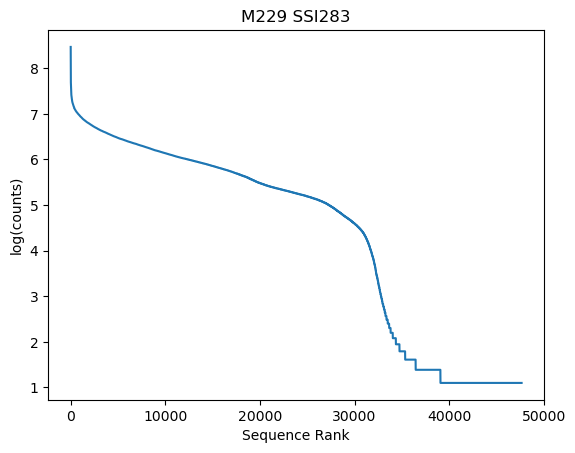

In [33]:
plotdf = outcdf[outcdf.counts > 2]
#plotdf['logcounts'] = np.log(plotdf.counts)
#  y axis. log of counts. 
#. x axis.  'sequence rank'

ax = sns.lineplot(data=plotdf, x= plotdf.index, y = 'logcounts')
ax.set(xlabel='Sequence Rank',
      ylabel='log(counts)',
      title = 'M229 SSI283')
plt.show()

In [30]:
#graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
#graph.map(sns.lineplot, y="counts")
#plt.show()

In [17]:
# use BC16  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

alldfs = []

for bch in bcolist[:1]:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    
    outfile = trim_fasta(cp, bch.filename, length=32)
    seqdf = make_fasta_df(cp, outfile)
    df = make_counts_df(cp, seqdf, bc_label=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)

    realcdf = make_counts_df(cp, realdf)
    spikecdf = make_counts_df(cp, spikedf)
    lonecdf = make_counts_df(cp, lonedf)    
    
    print(realdf)
    
    acrealdf = align_and_collapse(cp, realdf, dirname, base, 'real')
    acspikedf = align_and_collapse(cp, spikedf, dirname, base, 'spike')
    aclonedf = align_and_collapse(cp, lonedf, dirname, base, 'lone')
    
    acrealdf['type'] = 'real'
    acspikedf['type'] = 'spike'
    aclonedf['type'] = 'lone'
    
    outdf = merge_dfs([ acrealdf, acspikedf, aclonedf ])
    outdf['bc_label'] = base
    outdf.sort_values(by = ['type', 'counts'], ascending = [True, False], inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    alldfs.append(outdf)
    
alldfs
    
    #print(reals[0])

2023-04-17 19:28:02,175 (UTC) [ INFO ] core.py:352 root.trim_fasta(): wrote 7342 to /Users/jhover/project/mapseq/M205jupout/BC1.32.fasta
2023-04-17 19:28:02,243 (UTC) [ INFO ] core.py:327 root.make_fasta_df(): kept 7342 sequences out of 7342
2023-04-17 19:28:02,251 (UTC) [ INFO ] core.py:301 root.make_counts_df():                               sequence
0     TAAATGGACAACATCGTCCTAGGAATGAGTTC
1     ACCTGATGGCTGCTTACTTACTGCCGTCAGTC
2     GCCTAGGAACCACTAAGTGCGTAACGTCAGTC
3     ATTTTTACTCGCTCGAGAAGCAAACGTCAGTC
4     CCGTTGGGCGTAGTGGAACAAGAATGATGTTT
...                                ...
7337  TCAACAGCGTTTTGTGTACTAGCGTCAGTCTC
7338  GATATGTATCGCTGCACTCCCAGTCGTCAGTC
7339  AGGCTTGTCGTGCTAAGTCGCGGTTGGCGCTC
7340  CTTGGATTTAATTGCTAATTTCTTCGTCAGTC
7341  AGCCGGATAATAGTTGTTTGGTGCCGTCAGTC

[7342 rows x 1 columns]
2023-04-17 19:28:02,272 (UTC) [ INFO ] core.py:415 root.split_spike_real_lone_barcodes(): initial=3615 spikeins=2639 real=787 lone=94
2023-04-17 19:28:02,273 (UTC) [ INFO ] core.py:301 root.m

BC1 3615
                             sequence  counts bc_label
0    TAAATGGACAACATCGTCCTAGGAATGAGTTC     257      BC1
1    TGTGAGTATCAATTTGTCCGTTTTCATCCACT      78      BC1
2    GCCGTTAAATTACTAGTAACCAGCCCGTCTCC      76      BC1
3    CAATGAGCTTGGGCAAGGGGGCGGGAGTCACT      72      BC1
4    GCTCTCGAGACGTTGTCATAGTATAGGCCCCC      68      BC1
..                                ...     ...      ...
782  TGACGTGGGTATTGTACGTTTGAGGGGCCCTC       1      BC1
783  AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC       1      BC1
784  TGTTCAGTCGAATAACTTTTTTACTTCTGTCT       1      BC1
785  GGGTTTTGGTCGTGGATGGGTGTGCAATCACC       1      BC1
786  TAGGTGTCTTTTTATAGGCTGTTAAGGAGTTC       1      BC1

[787 rows x 3 columns]


2023-04-17 19:28:02,581 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:28:02,795 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.
2023-04-17 19:28:02,797 (UTC) [ INFO ] core.py:135 root.align_and_collapse(): handle bowtie align file: /Users/jhover/project/mapseq/M205jupout/BC1.real.bowtie
2023-04-17 19:28:02,813 (UTC) [ INFO ] core.py:230 root.get_components(): getting connected components from edgelist len=845
2023-04-17 19:28:02,817 (UTC) [ INFO ] core.py:235 root.get_components(): 758 components.
2023-04-17 19:28:02,818 (UTC) [ INFO ] core.py:141 root.align_and_collapse(): countdf columns are Index(['sequence', 'counts', 'bc_label'], dtype='object')
2023-04-17 19:28:02,819 (UTC) [ INFO ] core.py:189 root.collapse_counts_df(): collapsing countsdf len=787 w/ 758 components.
2023-04-17 19:28:04,146 (UTC) [ INFO ] core.py:216 root.collapse_counts_df(): original len=787 collapsed len=758
2023-04-17 19:28:04,149 (UTC) [ INFO ] core.py:374 root.

[                              sequence  counts bc_label   type
 0     TGTATATCCGGGCTTGAACCGTCAGTCTCGGA       3      BC1   lone
 1     TCGCGACTTCGCGCTCAGAATGGGAGGTATAG       3      BC1   lone
 2     GATCGCTATCTGTGTGTGTATAGCTCCGTCAG       3      BC1   lone
 3     GGGGATGTAAGTAAATTCGAGGCGACGGCTGG       2      BC1   lone
 4     ATCTATCAGTTCCCGCTGGCAACGCGTAATGA       2      BC1   lone
 ...                                ...     ...      ...    ...
 1384  GTTGAGAAGCTACTACGGTACAAGCGTCAGTC       2      BC1  spike
 1385  AGTTGGTTATGTCTCACATAGTAACGTCAGTC       2      BC1  spike
 1386  ATGCGTATTTCGCATTTGGAACAGCGTCAGTC       2      BC1  spike
 1387  CTTGCATTTTACAGCTTTCTGGACCGTCAGTC       2      BC1  spike
 1388  AGTGTGCTTTATATGTGTTTGACCCGTCAGTC       2      BC1  spike
 
 [1389 rows x 4 columns]]

In [18]:
bch = bcolist[3]
print(bch.label)
base = 'BC3'
aligner = cp.get('bcfasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

2023-04-17 19:31:27,030 (UTC) [ INFO ] utils.py:632 root.dataframe_to_seqlist(): made list of 787 SeqRecords
2023-04-17 19:31:27,036 (UTC) [ INFO ] bowtie.py:35 root.run_bowtie(): running allxall bowtie on /Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta -> /Users/jhover/project/mapseq/M205jupout/BC3.real.bowtie
2023-04-17 19:31:27,037 (UTC) [ INFO ] bowtie.py:60 root.run_bowtie(): running ['bowtie-build', '/Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta', '/Users/jhover/project/mapseq/M205jupout/indexes/BC3.real.seq']


BC4


2023-04-17 19:31:27,250 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:31:27,472 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,391,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,13:A>T
2,1,+,1,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
3,1,+,694,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,6:C>T
4,2,+,2,0,GCCGTTAAATTACTAGTAACCAGCCCGTCTCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
...,...,...,...,...,...,...,...,...
840,783,+,783,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
841,783,+,47,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,11:G>A
842,784,+,784,0,TGTTCAGTCGAATAACTTTTTTACTTCTGTCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
843,785,+,785,0,GGGTTTTGGTCGTGGATGGGTGTGCAATCACC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN


In [19]:
cp = get_default_config()
allfiles = [
'/Users/jhover/project/mapseq/M205testout/BC1.all.tsv','/Users/jhover/project/mapseq/M205testout/BC21.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC10.all.tsv','/Users/jhover/project/mapseq/M205testout/BC22.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC11.all.tsv','/Users/jhover/project/mapseq/M205testout/BC23.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC12.all.tsv','/Users/jhover/project/mapseq/M205testout/BC24.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC13.all.tsv','/Users/jhover/project/mapseq/M205testout/BC25.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC14.all.tsv','/Users/jhover/project/mapseq/M205testout/BC26.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC15.all.tsv','/Users/jhover/project/mapseq/M205testout/BC3.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC16.all.tsv','/Users/jhover/project/mapseq/M205testout/BC4.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC17.all.tsv','/Users/jhover/project/mapseq/M205testout/BC5.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC18.all.tsv','/Users/jhover/project/mapseq/M205testout/BC6.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC19.all.tsv','/Users/jhover/project/mapseq/M205testout/BC7.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC2.all.tsv','/Users/jhover/project/mapseq/M205testout/BC8.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC20.all.tsv','/Users/jhover/project/mapseq/M205testout/BC9.all.tsv'    
]
bcm, sbcm = process_merge_targets(cp, allfiles, outdir=None)
bcm

2023-04-17 19:31:34,962 (UTC) [ INFO ] core.py:700 root.process_merge_targets(): ['/Users/jhover/project/mapseq/M205testout/BC1.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC21.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC10.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC22.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC11.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC23.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC12.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC24.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC13.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC25.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC14.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC26.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC15.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC3.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC16.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC4.all.tsv', '/Users/j

bc_label,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,...,BC16,BC17,BC18,BC19,BC20,BC21,BC22,BC23,BC24,BC25
0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
1,0,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,51,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40172,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0
40173,0,0,0,0,0,0,0,0,0,0,...,13,0,0,0,0,0,0,0,0,0
40174,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
